# Import Libary

In [1]:
import numpy as np
import pandas as pd #for read csv
import matplotlib.pyplot as plt #for make plot
import nltk #for tokenization at preprocessing
import re # for regular expresion
import seaborn as sns # for show chart
import copy #for copy data

#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer #fit on texts, text to sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences #padding
from tensorflow.keras.layers import Embedding, LSTM, Dense #lstm layer
from tensorflow.keras.models import Sequential #neural network model
from tensorflow.keras.optimizers import Adam #optimizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #lemmatization
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory #remove stopword

from sklearn import metrics #mengukur performa model
from sklearn.model_selection import train_test_split #split data
from sklearn.preprocessing import LabelEncoder #for labeling class from index
from sklearn.metrics import classification_report, accuracy_score # for report classification
from sklearn.metrics import confusion_matrix # for confussion matrix

from gensim.models import Word2Vec #embedding word2vec
from gensim.models import FastText #embedding fasttext

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dataset

In [2]:
class Dataset:
    def getDataset(self):
        data = pd.read_csv('5000summarized.csv')
        return data

# Preprocessing

In [3]:
# Preprocessing:
class Preprocessing:
    def __init__(self):
        self.i = 0  # Inisialisasi variabel i di konstruktor
    def textPreprocessing(self, berita):
        print(self.i,"/5000")
        # Case folding
        berita = berita.lower()

        # Remove number
        berita = re.sub(r'\d+', '', berita)

        # Remove punctuation
        berita = re.sub(r'[^\w\s]', '', berita)

        # Tokenisasi
        token_berita = nltk.word_tokenize(berita)

        # Lematisasi
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        token_berita =[stemmer.stem(token) for token in token_berita]

        # Inisialisasi Sastrawi StopWordRemover
        stopword_factory = StopWordRemoverFactory()
        stopword_remover = stopword_factory.create_stop_word_remover()

        # Hapus stopwords
        token_berita = stopword_remover.remove(' '.join(token_berita)).split()
        
        # Gabungkan daftar kata-kata menjadi satu kalimat
        hasil_preprocessing = ' '.join(token_berita)
        self.i+=1
        return hasil_preprocessing
#         berita = berita.apply(lambda tokens: stopword_remover.remove(' '.join(tokens)).split())

# Max Length and Unique Word

In [4]:
class WordTokenization:
    def getUniqueWords(self, arr_sentences): 
        unique_words = 0
        max_word_length = 0
        min_word_length = float('inf')
          
        for i, text in enumerate(arr_sentences):
            current_length = len(text)
             # Memperbarui panjang kata maksimum
            if len(text) > max_word_length:
                max_word_length = current_length
            
            # Memperbarui panjang kata minimum
            if current_length < min_word_length:
                min_word_length = current_length    

        # Menghitung jumlah kata unik di dataset
        find_unique_word = set(word for text in arr_sentences for word in text)
        unique_words = len(find_unique_word)
        
        return unique_words, max_word_length, min_word_length

# Word2vec

vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True

In [5]:
#word2vec
class EmbeddingWord2Vec:
    def initializeWord2Vec(self, word_lists):
        model = Word2Vec(sentences=word_lists, vector_size=100, window=5, min_count=1, alpha=0.025, sg=0)
#         model.save("E:/ITHB/Semester 7/Tugas akhir/Model/Word2Vec/word2vec2.model")
        vocab = sorted(model.wv.key_to_index) #membuat daftar vocab berdasar index
        vector = model.wv[vocab] #mengambil vektor kata
        return vector 

# GloVe

In [6]:
class EmbeddingGloVe:
    def load_glove_embeddings(self, file_path):
        embeddings_index = {}
        with open(file_path, encoding="utf-8") as f:
            for line in f:
                word, coefs = line.split(maxsplit=1) #Memisahkan kata dan koefisien dari setiap baris
                coefs = np.fromstring(coefs, dtype='float32', sep=" ") #Mengubah string koefisien menjadi array NumPy(float)
                embeddings_index[word] = coefs #menyimpan kata dan vekor
        return embeddings_index
    def create_word_vectors_matrix(self, file_path):
        embeddings_index = self.load_glove_embeddings(file_path)
        embedding_matrix = np.zeros((len(embeddings_index), 100)) #membuat matrix 0 dengan size 100D

        for i, word in enumerate(embeddings_index):
            embedding_vector = embeddings_index[word] #Mendapatkan vektor embedding untuk kata tertentu.
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector #Menyimpan vektor embedding dalam matriks embedding pada baris ke-i.

        return embedding_matrix

# FastText

hs=0, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, word_ngrams=1, sample=0.001, seed=1, workers=3, min_alpha=0.0001, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, min_n=3, max_n=6, sorted_vocab=1, bucket=2000000, trim_rule=None, batch_words=10000, callbacks=(), max_final_vocab=None, shrink_windows=True

In [7]:
class EmbeddingFastText:
    def initializeFastText(self, word_lists):
        model = FastText(sentences=word_lists, vector_size=100, window=5, min_count=1, epochs=5, alpha=0.025, sg=0, min_n=3, max_n=6)
#         model.save("E:/ITHB/Semester 7/Tugas akhir/Model/FastText2.model")
        vocab = sorted(model.wv.key_to_index)
        vector = model.wv[vocab]
        return vector

# Long Short Term Memory

In [8]:
class GenerateModel:
    # Function for Create Model 
    def createModel(self, dimension, embedding_matrix_weight):
        custom_optimizer = Adam(learning_rate=0.001)
        model = Sequential()
        model.add(Embedding(input_dim=len(embedding_matrix_weight), output_dim=dimension, input_length=max_word_length, weights=[embedding_matrix_weight], trainable=False))
        model.add(LSTM(units=64)) #tanh(ct&ht), sigmoid =(it,ot,ft), Return sequences: False(return output untuk timestep terakhir)
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        print("=================================================================\n")
        print("                           MODEL SUMMARY\n")
        print("=================================================================\n")
        model.summary()
        return model
    
    # Function Create Plot Diagram Accuracy & Validation Accuracy
    def showPlotAccuracyModel(self, model):
        print("=================================================================\n")
        print("                        PLOT ACCURACY MODEL\n")
        print("=================================================================\n")
        # History Model Accuracy
        plt.plot(model.history['accuracy'])
        plt.plot(model.history['val_accuracy'])
        plt.title("Akurasi Model")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
    
    # Function Create Plot Diagram Loss & Validation Loss
    def showPlotLossModel(self, model):
        print("=================================================================\n")
        print("                          PLOT LOSS MODEL\n")
        print("=================================================================\n")
        # History Model Loss
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title("Loss Model")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
    
    # Create prediction using data training & classification report
    def createPredictionClassificationReport(self, model, X_test, Y_test): 
        print("=================================================================\n")
        print("                      CLASSIFICATION REPORT\n")
        print("=================================================================\n")
        predictions = model.predict(X_test)
        # Menentukan ambang batas
        threshold = 0.5
        
        # Konversi nilai probabilitas menjadi label kelas (binary classification)
        binary_predictions = [1 if p > threshold else 0 for p in predictions]
        
        # Menghitung akurasi dengan accuracy_score
        accuracy = accuracy_score(Y_test, binary_predictions)
        
        # Mencetak akurasi
        print("Accuracy: ", accuracy)
        print(classification_report(Y_test, binary_predictions, labels=[1, 0], target_names=["hoax", "valid"]))
        return predictions
    
    # Create Evaluate Loss & Accuracy for data testing
    def showEvaluateModel(self, model, X_test, Y_test): 
        print("=================================================================\n")
        print("                         EVALUATE MODEL\n")
        print("=================================================================\n")
        evaluate = model.evaluate(X_test, Y_test)
        print("Accuracy : ", evaluate[1], "\n")
        print("Loss : ", evaluate[0], "\n")
        
    # Confusion Matrix
    def showConfusionMatrix(self, Y_actual, Y_predicted):
        print("=================================================================\n")
        print("                       CONFUSION MATRIX\n")
        print("=================================================================\n")
        threshold = 0.5

        # Konversi nilai probabilitas menjadi label kelas (binary classification)
        binary_actual = [1 if y > threshold else 0 for y in Y_actual]
        binary_predicted = [1 if p > threshold else 0 for p in Y_predicted]
    
        cm = metrics.confusion_matrix(binary_actual, binary_predicted)
        df_cm = pd.DataFrame(cm, index=["valid", "hoax"], columns=["valid", "hoax"])
        plt.figure(figsize = (6,4))
        heatmap = sns.heatmap(df_cm, annot=True, fmt ="d")
        heatmap.set(xlabel='Predicted Label', ylabel='Actual Label')
        plt.show()
        return df_cm
    
    def getAccuracyClassHoax(self, df_cm):
        TP = df_cm['hoax']['hoax']
        TN = df_cm['valid']['valid'] 
        FP = df_cm['valid']['hoax']
        FN = df_cm['hoax']['valid']
        return (TP+TN)/(TP+FP+TN+FN)
    
    def getAccuracyClassValid(self, df_cm):
        TP = df_cm['valid']['valid']
        TN = df_cm['hoax']['hoax']
        FP = df_cm['hoax']['valid']
        FN = df_cm['valid']['hoax']
        return (TP+TN)/(TP+FP+TN+FN)
    
    # Show Accuracy Each Class
    def showAccuracyEachClass(self, df_cm):
        print("=================================================================\n")
        print("                       ACCURACY EACH CLASS\n")
        print("=================================================================\n")
        print("Accuracy Valid: ", self.getAccuracyClassValid(df_cm))
        print("Accuracy Hoax: ", self.getAccuracyClassHoax(df_cm))
    
    def saveModel(self, model, index):
        model.save('/Users/Asus/Tugas Akhir/Experiment/Model/' + str(index))

    def loadModel(self, index):
        new_model = tf.keras.models.load_model('/Users/Asus/Tugas Akhir/Experiment/Model/' + str(index))
        return new_model

# Initialization

In [9]:
dataset = Dataset()
preprocessing = Preprocessing()
tokenizer = WordTokenization()
tokenizerKeras = Tokenizer()
word2vec = EmbeddingWord2Vec()
glove = EmbeddingGloVe()
fasttext = EmbeddingFastText()
generate_model = GenerateModel()

# Get Dataset

In [10]:
data = dataset.getDataset()
data

,label,summarized
0,0,Mantan Gubernur DKI Jakarta Anies Baswedan men...
1,0,Gubernur Sumatera Utara Edy Rahmayadi membuka ...
2,0,PKB bakal mengusung Menteri Ketenagakerjaan Id...
3,0,Ketua Umum Partai Kebangkitan Nusantara (PKN) ...
4,0,Dewan Pimpinan Pusat PKN menyiapkan jabatan kh...
...,...,...
4757,1,Beberapa waktu lalu sempat beredar sebuah pesa...
4758,1,Sebuah gua bernama Gua Tao 8 Putri yang berada...
4759,1,Program kuota belajar pulsa 250rb dan kuota 75...
4760,1,Pasangan kekasih gancet diduga pelaku kena Aza...


# Text Preprocessing

melakukan text preprocessing

In [11]:
# cleanData = data['summarized'].apply(preprocessing.textPreprocessing)
# cleanData

menyimpan csv hasil preprocessing

In [12]:
# # saving the dataframe
# cleanData.to_csv('clean_dataset4.csv', header=False, index=False)

read csv yang sudah di preprocessing

In [13]:
#read new file
cleanData = pd.read_csv('clean_dataset5000_pertama_translated.csv', header=None, names=['text_berita'])
cleanData

,text_berita
0,"former governor of DKI Jakarta, Anies Baswedan..."
1,"The Governor of North Sumatra, Edy Rahmayadi, ..."
2,"PKB will nominate the Minister of Manpower, Id..."
3,General Chairperson of the Indonesian Rise of ...
4,The PKN Central Leadership Council is ready fo...
...,...
4757,Some time ago there was a personal message cir...
4758,"cave fruit, cave name, tao putri deli, serdang..."
4759,RB credit teaching quota program GB quota lect...
4760,"put up love, cheat, suspect that if you sell, ..."


# Data Split

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(cleanData, data['label'], test_size=0.2, random_state=42)
print("Data Pelatihan (X):")
print(X_train)
print("Label Pelatihan (y):")
print(Y_train)

print("\nData Pengujian (X):")
print(X_test)
# X_test.to_csv('xtest.csv', header=False, index=False)
print("Label Pengujian (y):")
print(Y_test)
# Y_test.to_csv('ytest.csv', header=False, index=False)

Data Pelatihan (X):
                                            text_berita
2763  real secret room skulls not only brigadier j w...
2547  Kraken enters RI and is most contagious throug...
624   Mayor of Surakarta and the first son of Presid...
1777  discourse on the duet of the mayor of Solo, Gi...
2688  mzee john nandi born year john celebrated year...
...                                                 ...
4426  Gajah Mada TV YouTube channel uploads video ti...
466   Gibran Rakabuming was reluctant to answer in a...
3092  God, look at how the Chinese make eggs. Google...
3772  Russian colonialists raise the flag of the Sov...
860   The Democratic Party removed the position of d...

[3809 rows x 1 columns]
Label Pelatihan (y):
2763    1
2547    1
624     0
1777    0
2688    1
       ..
4426    1
466     0
3092    1
3772    1
860     0
Name: label, Length: 3809, dtype: int64

Data Pengujian (X):
                                            text_berita
828   head of body wins milu bappil

In [15]:
dataTokenizationTrain = [nltk.word_tokenize(sentence)for sentence in X_train['text_berita']] #tokenisasi kalimat di x_train
dataTokenizationTest = [nltk.word_tokenize(sentence)for sentence in X_test['text_berita']] #tokenisasi kalimat di x_test
dataTokenization = [*dataTokenizationTrain, *dataTokenizationTest] #menggabungkan xtrain dan test untuk dicari max length nya
print("Count Item Text:", len(dataTokenization))
print(dataTokenization[:10])

Count Item Text: 4762
[['real', 'secret', 'room', 'skulls', 'not', 'only', 'brigadier', 'j', 'who', 'is', 'occupied', 'by', 'smbobesarcnncnnen', 'ter'], ['Kraken', 'enters', 'RI', 'and', 'is', 'most', 'contagious', 'through', 'antibodies'], ['Mayor', 'of', 'Surakarta', 'and', 'the', 'first', 'son', 'of', 'President', 'Joko', 'Widodo', ',', 'Gibran', 'Rakabuming', 'Jokowi', ',', 'said', 'that', 'his', 'younger', 'brother', ',', 'Kaesang', 'Pangarep', ',', 'entered', 'the', 'world', 'of', 'politics', ',', 'even', 'though', 'he', 'knew', 'he', 'was', 'starting', 'to', 'get', 'involved', 'in', 'politics', ',', 'he', 'had', 'invited', 'Kawir', 'Jokowi', ',', 'several', 'infrastructure', 'projects', 'were', 'in', 'the', 'process', 'of', 'being', 'worked', 'on', 'in', 'the', 'city', 'of', 'Solo', ',', 'as', 'long', 'as', 'a', 'political', 'party', 'wanted', 'to', 'join', 'the', 'party', 'leader', ',', 'I', 'know', 'so', 'that', 'the', 'money', 'would', 'break', 'up', '.', 'I', 'think', 'it', 

In [16]:
unique_words, max_word_length, min_word_length = tokenizer.getUniqueWords(dataTokenization)
print("min word length : ", min_word_length) #4348
print("Max word length : ", max_word_length) #574
print("Vocabulary Size : ", unique_words)

min word length :  1
Max word length :  335
Vocabulary Size :  28933


In [17]:
# padded_train, padded_test = tokenizer.paddingSequence(X_train['text_berita'], X_test['text_berita'], max_word_length)
tokenizerKeras.fit_on_texts(dataTokenizationTrain)
tokenizerKeras.fit_on_texts(dataTokenizationTest)
sequencesTrain = tokenizerKeras.texts_to_sequences(dataTokenizationTrain)
sequencesTest = tokenizerKeras.texts_to_sequences(dataTokenizationTest)
#for word2vec
padded_sequences_train = pad_sequences(sequencesTrain, maxlen=max_word_length, padding='pre')
padded_sequences_test = pad_sequences(sequencesTest, maxlen=max_word_length, padding='pre')
print(padded_sequences_train)
print(padded_sequences_train.shape)
#for glove
padded_sequences_train2=copy.copy(padded_sequences_train)
padded_sequences_test2=copy.copy(padded_sequences_test)
#for fasttext
padded_sequences_train3=copy.copy(padded_sequences_train)
padded_sequences_test3=copy.copy(padded_sequences_test)
# print("train",'\n',padded_sequences_train[:2])

[[    0     0     0 ...    80 10897  6741]
 [    0     0     0 ...  5202   565  3582]
 [    0     0     0 ...    35   134     6]
 ...
 [    0     0     0 ...   177     1   209]
 [    0     0     0 ...   200    10 10713]
 [    0     0     0 ...   833  4638     6]]
(3809, 335)


# Model Word2Vec

In [99]:
word2vec100d = word2vec.initializeWord2Vec(np.concatenate((padded_sequences_train, padded_sequences_test), axis=0).tolist())
print("Embedding Matrix (100):\n", word2vec100d[:2], "\n")

Embedding Matrix (100):
 [[ 0.6834671  -1.5421178  -1.1192737  -0.23305939  3.4562993   1.6355579
   0.14131123  2.2639546  -0.24767289  0.6432494  -1.1364089  -0.88560486
   1.2494277   3.0753734   0.3904482   1.0266904  -0.84455454  0.96704376
   0.54807645 -0.21765208  1.714993   -1.1578325  -0.526671    0.21891189
   1.1013931   0.05176101 -0.36473706 -0.05268415  0.9876787   0.6500747
   2.185443    1.833219    0.44058564  1.507249    0.5249399   0.3446002
  -1.1979448  -0.25059897  0.21197312 -0.6061104   0.40384194 -1.3786168
  -0.03550746 -0.9993817   0.13035078 -1.651566   -0.856287   -2.2571077
  -0.13249598  0.37823284  0.6394391  -3.0319002   0.5787136   0.15250956
  -0.6198383   1.7368009   0.75860494 -0.561016    0.41418257 -1.2953427
  -1.3372918  -2.024208    3.6517606   0.1720553  -2.4689884   1.420802
   0.7364713  -0.26727736 -1.0601459  -0.01903145 -1.7072456  -0.07420567
   0.8031361   0.8892577  -1.2675766  -2.2370172   1.3420221  -1.7702574
  -1.1983079   0.11184

# Model Glove

In [100]:
glove100d = glove.create_word_vectors_matrix('glove.6B.100d.txt')
print("Embedding Matrix (100d):\n", glove100d[:3], "\n")

Embedding Matrix (100d):
 [[-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
  -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
   0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
  -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
   0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
  -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
   0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
   0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
  -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
  -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
  -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
  -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
  -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
  -1.25259995  0.071624    0.7056

# Model FastText

In [30]:
fastText100d = fasttext.initializeFastText(np.concatenate((padded_sequences_train3, padded_sequences_test3), axis=0).tolist())
print("Embedding Matrix (100):\n", fastText100d[:3], "\n")

Embedding Matrix (100):
 [[ 2.70703793e-01  3.65337300e+00  1.73306274e+00 -9.92918205e+00
   1.21181715e+00 -3.54668570e+00 -2.64408588e+00  6.90593243e+00
  -5.45327330e+00  4.18559492e-01  6.72774911e-01 -6.13834858e+00
   2.38351256e-01 -8.46255898e-01  2.41523075e+00  9.15833473e+00
   1.13784418e+01 -2.26166224e+00  3.03722620e+00 -1.78808937e+01
  -5.36878109e+00 -4.55047798e+00  5.87045145e+00 -2.02481461e+00
   3.80369377e+00  5.52437186e-01 -3.33232832e+00  3.93053341e+00
   1.26100528e+00 -2.77763653e+00 -2.56160021e-01  1.28988877e-01
   1.09093666e+01 -5.70541191e+00 -4.94446278e-01  1.31919336e+00
   1.46754742e+00  1.43843091e+00  1.63496470e+00 -1.99527669e+00
  -1.79342437e+00  3.96264601e+00 -3.64738512e+00  6.49212956e-01
  -4.04806793e-01  1.39634418e+00 -7.13812828e-01 -1.88902009e+00
   3.39642668e+00  1.34106121e+01 -8.66071510e+00  1.10472620e+00
   9.31713104e-01  6.18662357e-01  1.41672921e+00 -1.78742099e+00
   5.02287483e+00  3.45861101e+00  1.13843560e+00  

# Word2vec

In [96]:
model = generate_model.createModel(100, word2vec100d)


                           MODEL SUMMARY


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 335, 100)          3421700   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3464005 (13.21 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 3421700 (13.05 MB)
_________________________________________________________________


In [97]:
lstm = model.fit(padded_sequences_train, Y_train, validation_data=(padded_sequences_test, Y_test), epochs = 30, batch_size=128 )

Epoch 1/30
30/30 [==============================] - 25s 728ms/step - loss: 0.4889 - accuracy: 0.7540 - val_loss: 0.2871 - val_accuracy: 0.8951
Epoch 2/30
30/30 [==============================] - 20s 663ms/step - loss: 0.2680 - accuracy: 0.8973 - val_loss: 0.2509 - val_accuracy: 0.9171
Epoch 3/30
30/30 [==============================] - 20s 671ms/step - loss: 0.2017 - accuracy: 0.9346 - val_loss: 0.2752 - val_accuracy: 0.9171
Epoch 4/30
30/30 [==============================] - 21s 699ms/step - loss: 0.2406 - accuracy: 0.8863 - val_loss: 0.2081 - val_accuracy: 0.8961
Epoch 5/30
30/30 [==============================] - 19s 639ms/step - loss: 0.1973 - accuracy: 0.9425 - val_loss: 0.1002 - val_accuracy: 0.9769
Epoch 6/30
30/30 [==============================] - 19s 635ms/step - loss: 0.2930 - accuracy: 0.8934 - val_loss: 0.4020 - val_accuracy: 0.8384
Epoch 7/30
30/30 [==============================] - 18s 591ms/step - loss: 0.3320 - accuracy: 0.8669 - val_loss: 0.2513 - val_accuracy: 0.9161


                        PLOT ACCURACY MODEL




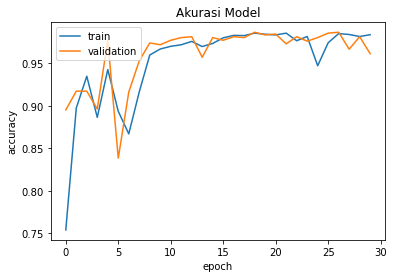

In [98]:
# create plot accuracy & val accuracy
generate_model.showPlotAccuracyModel(lstm)


                          PLOT LOSS MODEL




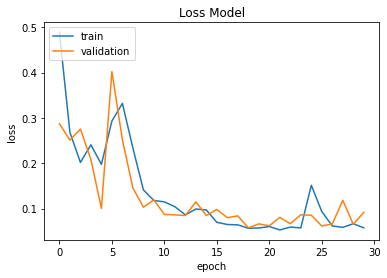

In [99]:
# create plot loss & val loss
generate_model.showPlotLossModel(lstm)

In [100]:
# create classification report
predictions = generate_model.createPredictionClassificationReport(model, padded_sequences_test, Y_test)


                      CLASSIFICATION REPORT


30/30 [==============================] - 3s 82ms/step
Accuracy:  0.9611752360965372
              precision    recall  f1-score   support

        hoax       1.00      0.93      0.96       469
       valid       0.93      1.00      0.96       484

    accuracy                           0.96       953
   macro avg       0.96      0.96      0.96       953
weighted avg       0.96      0.96      0.96       953



In [101]:
# Konversi array NumPy menjadi DataFrame
y_test_pred = pd.DataFrame(predictions)

# Simpan DataFrame ke file Excel
y_test_pred.to_excel('predictions.xlsx', header=False, index=False)

In [102]:
# show evaluate model (loss & accuracy)
generate_model.showEvaluateModel(model, padded_sequences_test, Y_test)


                         EVALUATE MODEL


30/30 [==============================] - 3s 83ms/step - loss: 0.0917 - accuracy: 0.9612
Accuracy :  0.961175262928009 

Loss :  0.09174048900604248 




                       CONFUSION MATRIX




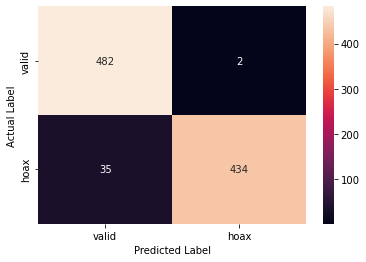

In [103]:
# show confusion matrix
df_cm = generate_model.showConfusionMatrix(Y_test, predictions)

In [104]:
generate_model.showAccuracyEachClass(df_cm)


                       ACCURACY EACH CLASS


Accuracy Valid:  0.9611752360965372
Accuracy Hoax:  0.9611752360965372


In [105]:
# generate_model.saveModel(model, 125)

In [106]:
loaded_model = generate_model.loadModel(125)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 335, 100)          3421700   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 3464005 (13.21 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 3421700 (13.05 MB)
_________________________________________________________________


# Glove 

In [31]:
model = generate_model.createModel(100, glove100d)


                           MODEL SUMMARY


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 335, 100)          40000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 40042305 (152.75 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 40000000 (152.59 MB)
_________________________________________________________________


In [32]:
lstm = model.fit(padded_sequences_train, Y_train, validation_data=(padded_sequences_test2, Y_test), epochs = 30, batch_size=128)

Epoch 1/30
30/30 [==============================] - 21s 605ms/step - loss: 0.8338 - accuracy: 0.5062 - val_loss: 0.6872 - val_accuracy: 0.5656
Epoch 2/30
30/30 [==============================] - 16s 551ms/step - loss: 0.6804 - accuracy: 0.5731 - val_loss: 0.6817 - val_accuracy: 0.5708
Epoch 3/30
30/30 [==============================] - 17s 574ms/step - loss: 0.6673 - accuracy: 0.5954 - val_loss: 0.6906 - val_accuracy: 0.5656
Epoch 4/30
30/30 [==============================] - 17s 566ms/step - loss: 0.6435 - accuracy: 0.6277 - val_loss: 0.7168 - val_accuracy: 0.5614
Epoch 5/30
30/30 [==============================] - 18s 598ms/step - loss: 0.6187 - accuracy: 0.6524 - val_loss: 0.7375 - val_accuracy: 0.5519
Epoch 6/30
30/30 [==============================] - 17s 577ms/step - loss: 0.5856 - accuracy: 0.6876 - val_loss: 0.7342 - val_accuracy: 0.5729
Epoch 7/30
30/30 [==============================] - 18s 595ms/step - loss: 0.5634 - accuracy: 0.6949 - val_loss: 0.7785 - val_accuracy: 0.5540


                        PLOT ACCURACY MODEL




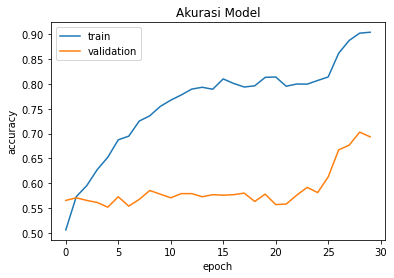

In [33]:
# create plot accuracy & val accuracy
generate_model.showPlotAccuracyModel(lstm)


                          PLOT LOSS MODEL




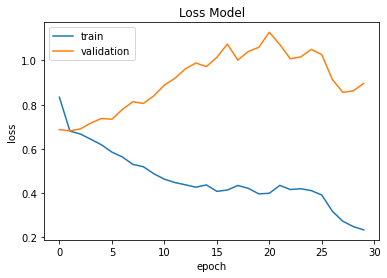

In [34]:
# create plot loss & val loss
generate_model.showPlotLossModel(lstm)

In [35]:
# create classification report
predictions = generate_model.createPredictionClassificationReport(model, padded_sequences_test2, Y_test)


                      CLASSIFICATION REPORT


30/30 [==============================] - 4s 119ms/step
Accuracy:  0.6935991605456453
              precision    recall  f1-score   support

        hoax       0.66      0.78      0.71       469
       valid       0.74      0.61      0.67       484

    accuracy                           0.69       953
   macro avg       0.70      0.69      0.69       953
weighted avg       0.70      0.69      0.69       953



In [36]:
# show evaluate model (loss & accuracy)
generate_model.showEvaluateModel(model, padded_sequences_test2, Y_test)


                         EVALUATE MODEL


30/30 [==============================] - 3s 106ms/step - loss: 0.8966 - accuracy: 0.6936
Accuracy :  0.6935991644859314 

Loss :  0.8965814113616943 




                       CONFUSION MATRIX




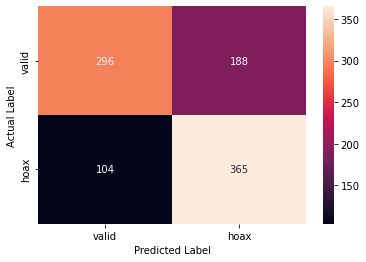

In [37]:
# show confusion matrix
df_cm = generate_model.showConfusionMatrix(Y_test, predictions)

In [38]:
generate_model.showAccuracyEachClass(df_cm)


                       ACCURACY EACH CLASS


Accuracy Valid:  0.6935991605456453
Accuracy Hoax:  0.6935991605456453


In [39]:
# generate_model.saveModel(model, 225)

INFO:tensorflow:Assets written to: /Users/Asus/Tugas Akhir/Experiment/Model/227\assets


INFO:tensorflow:Assets written to: /Users/Asus/Tugas Akhir/Experiment/Model/227\assets


In [40]:
loaded_model = generate_model.loadModel(225)
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 335, 100)          40000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 40042305 (152.75 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 40000000 (152.59 MB)
_________________________________________________________________


# FastText 

In [41]:
model = generate_model.createModel(100, fastText100d)


                           MODEL SUMMARY


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 335, 100)          3421700   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3464005 (13.21 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 3421700 (13.05 MB)
_________________________________________________________________


In [42]:
lstm = model.fit(padded_sequences_train, Y_train, validation_data=(padded_sequences_test3, Y_test), epochs = 30, batch_size=128)

Epoch 1/30
30/30 [==============================] - 30s 874ms/step - loss: 0.5733 - accuracy: 0.7112 - val_loss: 0.4027 - val_accuracy: 0.8153
Epoch 2/30
30/30 [==============================] - 27s 898ms/step - loss: 0.4415 - accuracy: 0.8002 - val_loss: 0.4436 - val_accuracy: 0.7933
Epoch 3/30
30/30 [==============================] - 27s 919ms/step - loss: 0.4196 - accuracy: 0.8041 - val_loss: 0.3620 - val_accuracy: 0.8489
Epoch 4/30
30/30 [==============================] - 23s 766ms/step - loss: 0.4076 - accuracy: 0.8149 - val_loss: 0.4221 - val_accuracy: 0.7996
Epoch 5/30
30/30 [==============================] - 27s 906ms/step - loss: 0.4024 - accuracy: 0.8183 - val_loss: 0.4172 - val_accuracy: 0.8122
Epoch 6/30
30/30 [==============================] - 24s 790ms/step - loss: 0.4092 - accuracy: 0.8186 - val_loss: 0.4925 - val_accuracy: 0.7324
Epoch 7/30
30/30 [==============================] - 24s 815ms/step - loss: 0.5252 - accuracy: 0.7522 - val_loss: 0.5023 - val_accuracy: 0.7503


                        PLOT ACCURACY MODEL




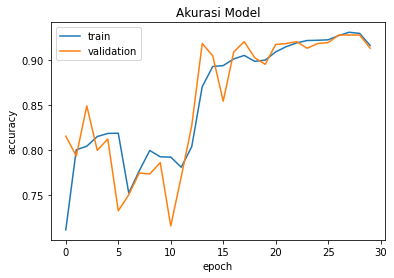

In [43]:
# create plot accuracy & val accuracy
generate_model.showPlotAccuracyModel(lstm)


                          PLOT LOSS MODEL




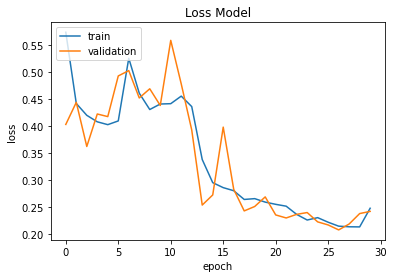

In [44]:
# create plot loss & val loss
generate_model.showPlotLossModel(lstm)

In [45]:
# create classification report
predictions = generate_model.createPredictionClassificationReport(model, padded_sequences_test3, Y_test)


                      CLASSIFICATION REPORT


30/30 [==============================] - 4s 106ms/step
Accuracy:  0.912906610703043
              precision    recall  f1-score   support

        hoax       0.98      0.84      0.90       469
       valid       0.87      0.98      0.92       484

    accuracy                           0.91       953
   macro avg       0.92      0.91      0.91       953
weighted avg       0.92      0.91      0.91       953



In [46]:
# show evaluate model (loss & accuracy)
generate_model.showEvaluateModel(model, padded_sequences_test3, Y_test)


                         EVALUATE MODEL


30/30 [==============================] - 3s 108ms/step - loss: 0.2419 - accuracy: 0.9129
Accuracy :  0.9129065871238708 

Loss :  0.24188163876533508 




                       CONFUSION MATRIX




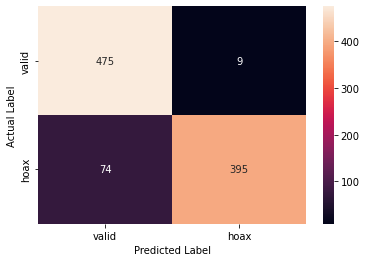

In [47]:
# show confusion matrix
df_cm = generate_model.showConfusionMatrix(Y_test, predictions)

In [48]:
generate_model.showAccuracyEachClass(df_cm)


                       ACCURACY EACH CLASS


Accuracy Valid:  0.912906610703043
Accuracy Hoax:  0.912906610703043


In [49]:
# generate_model.saveModel(model, 325)

INFO:tensorflow:Assets written to: /Users/Asus/Tugas Akhir/Experiment/Model/327\assets


INFO:tensorflow:Assets written to: /Users/Asus/Tugas Akhir/Experiment/Model/327\assets


In [50]:
loaded_model = generate_model.loadModel(325)
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 335, 100)          3421700   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3464005 (13.21 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 3421700 (13.05 MB)
_________________________________________________________________


# GUI

In [18]:
# GUI
!pip install flask
!pip install flask_ngrok
from flask import Flask, render_template, request, jsonify #render template HTML, akses ke data yang dikirimkan oleh klien ke server, mengubah objek Python menjadi respons JSON.
from flask_ngrok import run_with_ngrok #akses server Flask Anda melalui URL publik, integrasikan ngrok dengan server Flask Anda 

In [19]:
class GUI:

    def __init__(self):
        template_path = '/Users/Asus/Tugas Akhir/GUI/templates'
        static_path = '/Users/Asus/Tugas Akhir/GUI/static'
        self.app = Flask(__name__, template_folder=template_path, static_folder=static_path)
        self.hoax_model_generator = GenerateModel()

    def start_gui(self):
        run_with_ngrok(self.app)

        @self.app.route("/")
        def home():
            return render_template('index.html')

        @self.app.route('/predict', methods=['POST'])
        def predict():
            data = request.get_json()
            text_input = data['textInput']
            print('text:',text_input)
            
            #tokenization for embedding
            dataTokenization = [nltk.word_tokenize(text_input)]
            
            # Menyusun kamus kata-kata berdasarkan teks
            tokenizerKeras.fit_on_texts(dataTokenization)
            
            # Tokenisasi teks dan konversi menjadi vektor
            sequence = tokenizerKeras.texts_to_sequences(dataTokenization)
            print('sequence :',sequence)
            padded_sequence = pad_sequences(sequence, maxlen=max_word_length, padding='pre')
            print('padded_sequence',padded_sequence)
            print(padded_sequence.shape)
            
            # Load model
            model = self.hoax_model_generator.loadModel(125)
            model.summary()
            
            # Lakukan prediksi menggunakan model
            prediction = model.predict(padded_sequence)
            print(prediction)
            
            # Tampilkan hasil prediksi
            threshold =0.5
            result = "Hoax" if prediction >threshold else "Valid"

            # Return the prediction as a JSON response
            return jsonify({'prediction': result})

        self.app.run()

In [20]:
gui = GUI()
gui.start_gui()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Dec/2023 13:00:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/browser.min.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/jquery.scrolly.min.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/breakpoints.min.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/jquery.scrollex.min.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/util.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/js/jquery.min.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2023 13:00:33] "GET /static/favicon.ico HTTP/1.1" 404 -
Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\lib\site-packages\urllib3\connect

text: Presidential candidate number 1 Anies Baswedan's remarks about the founder of the Republic of Indonesia building a country not for children and nephews were shot back by TKN Prabowo Subianto-Gibran Rakabuming Raka. Various comments from TKN Prabowo-Gibran officials responded to Anies' statement.
Anies spoke about the founder of the Republic of Indonesia who did not prioritize his own personality or group when visiting Bung Karno's exile house in Bengkulu, Wednesday (6/12). Anies saw several historical collections from Indonesia's first President. Anies also took time to wash his face at the well located behind the historic house.

"This republic was founded by educated individuals, intellectuals, intellectuals, whose minds were formed not only by reading, but by life experience. They experienced oppression, they experienced detention, and they had broad insight," said Anies, in a written statement. , Thursday (7/12).

Anies invited all parties to return to Indonesia's ideals, nam

127.0.0.1 - - [14/Dec/2023 13:00:55] "POST /predict HTTP/1.1" 200 -


[[0.00850807]]
